In [1]:
import pandas as pd

In [2]:
## clean dataset

In [3]:
### load cleaned dataset


In [93]:
odir_df = pd.read_csv('odir-5k-parsed.csv')
odir_df.head()

,id,age_group,age,gender,l_diagnostic_keywords,r_diagnostic_keywords,normal,diabetes,glaucoma,cataract,amd,hypertension,myopia,other,labels,target,filename
0,0,60-69,69,1,cataract,normal fundus,0,0,0,1,0,0,0,0,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,50-59,57,0,normal fundus,normal fundus,1,0,0,0,0,0,0,0,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,40-49,42,0,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,50-59,53,0,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,40-49,50,1,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [76]:
import argparse
import ast
import os
import time
import random
import matplotlib.pyplot as plt
import numpy as np
from box import ConfigBox
import pandas as pd
from PIL import Image
import logging

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import f1_score
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path


In [77]:
dataset = 'ODIR5K'

notebook_dir = Path.cwd()
artifacts = notebook_dir.resolve().parents[1] / 'shared' / 'artifacts'
odir_processed_dir = artifacts / 'processed' / dataset
odir_raw_dir = artifacts / 'raw' / dataset

image_dir = odir_raw_dir / 'preprocessed_images'

print(notebook_dir)
print(artifacts)
print(odir_processed_dir)
print(odir_raw_dir)

/Users/ismasadou/Documents/kuude/jamu-platform/model-development/research
/Users/ismasadou/Documents/kuude/jamu-platform/shared/artifacts
/Users/ismasadou/Documents/kuude/jamu-platform/shared/artifacts/processed/ODIR5K
/Users/ismasadou/Documents/kuude/jamu-platform/shared/artifacts/raw/ODIR5K


In [78]:
##########################################
# 1. Command-Line Argument Parsing
##########################################
def parse_args():
    parser = argparse.ArgumentParser(
        description="Fine-tune a pretrained CNN with industry-level improvements."
    )
    parser.add_argument("--csv", type=str, default="odir-5k-parsed.csv", help="Path to the CSV file with data.")
    parser.add_argument("--num_classes", type=int, default=8, help="Number of classes.")
    parser.add_argument("--batch_size", type=int, default=32, help="Batch size for training.")
    parser.add_argument("--num_epochs", type=int, default=50, help="Maximum number of epochs.")
    parser.add_argument("--lr", type=float, default=0.001, help="Initial learning rate.")
    parser.add_argument("--patience", type=int, default=5, help="Early stopping patience.")
    parser.add_argument("--seed", type=int, default=42, help="Random seed for reproducibility.")
    parser.add_argument("--log_dir", type=str, default="runs/experiment1", help="Directory for TensorBoard logs and checkpoints.")
    parser.add_argument("--checkpoint", type=str, default="", help="Path to resume checkpoint (optional).")
    return parser.parse_args()

default_args = {
    "image_dir":image_dir,
    "csv": "odir-5k-parsed.csv",
    "num_classes": 8,
    "batch_size": 32,
    "num_epochs": 50,
    "lr": 0.001,
    "patience": 5,
    "seed": 42,
    "log_dir": "runs/experiment1",
    "checkpoint": ""
}

args = ConfigBox(default_args)
# args = parse_args()



In [79]:
##########################################
# 2. Setup Logging and Random Seed
##########################################
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Starting training script with arguments: %s", args)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(args.seed)
os.makedirs(args.log_dir, exist_ok=True)

2025-02-08 09:30:12,441 - INFO - Starting training script with arguments: {'image_dir': PosixPath('/Users/ismasadou/Documents/kuude/jamu-platform/shared/artifacts/raw/ODIR5K/preprocessed_images'), 'csv': 'odir-5k-parsed.csv', 'num_classes': 8, 'batch_size': 32, 'num_epochs': 50, 'lr': 0.001, 'patience': 5, 'seed': 42, 'log_dir': 'runs/experiment1', 'checkpoint': ''}


In [80]:
# ##########################################
# # Hyperparameters and Configurations
# ##########################################
# csv_file = 'odir-5k-parsed.csv'  # Path to your CSV file.
# num_classes = 8             # Adjust based on your data.
# batch_size = 32
# num_epochs = 50             # Maximum epochs.
# lr = 0.001                  # Initial learning rate.
# patience = 5                # For early stopping.
# scheduler_patience = 3      # For LR scheduler (if no improvement in these many epochs, LR is reduced).
# lr_decay_factor = 0.5       # Factor to reduce LR.

# log_dir = "runs/experiment1"  # TensorBoard log directory.
# os.makedirs(log_dir, exist_ok=True)

In [96]:
##########################################
# Custom Dataset Definition
##########################################
class ImageDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to CSV with columns 'path' and 'target' (a one-hot encoded string, e.g., "[1,0,0,0,0,0]").
            transform (callable, optional): Transform to be applied on an image.
        """
        self.image_dir = image_dir
        files = notebook_dir / csv_file
        print(files)
        self.data = pd.read_csv(notebook_dir / csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = self.image_dir / row['filename']
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Convert one-hot target (string) to an integer label.
        target_list = ast.literal_eval(row['target'])
        label = target_list.index(1)
        return image, label

In [97]:
##########################################
# 4. Data Transforms and Dataset Splitting
##########################################
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ResNet.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset.
full_dataset = ImageDataset(args.image_dir,args.csv, transform=transform)
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Compute weights for the training set to balance classes.
train_labels = [full_dataset[idx][1] for idx in train_dataset.indices]
class_counts = np.bincount(train_labels, minlength=args.num_classes)
class_counts = np.where(class_counts == 0, 1, class_counts)  # Avoid division by zero.
class_weights = 1.0 / class_counts
samples_weight = [class_weights[label] for label in train_labels]
samples_weight = torch.DoubleTensor(samples_weight)
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)

/Users/ismasadou/Documents/kuude/jamu-platform/model-development/research/odir-5k-parsed.csv


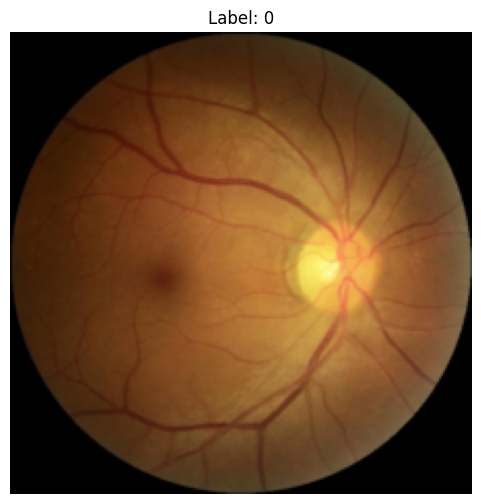

In [83]:
def imshow(img, title=None):
    """
    Unnormalize and display a tensor image.
    
    Args:
        img (torch.Tensor): Image tensor of shape (C, H, W) that has been normalized.
        title (str, optional): Title to display on the plot.
    """
    # Convert the tensor image to a NumPy array and change the channel order from (C, H, W) to (H, W, C)
    img_np = img.cpu().numpy().transpose((1, 2, 0))
    
    # The normalization used in the transform is:
    #    normalized = (x - mean) / std
    # To unnormalize, multiply by std and add the mean back:
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    
    # Clip the values to be between 0 and 1
    img_np = np.clip(img_np, 0, 1)
    
    # Plot the image using matplotlib
    plt.figure(figsize=(6,6))
    plt.imshow(img_np)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Now, get a sample from the dataset.
# This assumes you have already defined 'full_dataset' as in the previous code snippet.
sample_index = 50  # You can change this index to visualize a different sample.
sample_img, sample_label = full_dataset[sample_index]

# Display the image along with its label.
imshow(sample_img, title=f"Label: {sample_label}")

In [85]:
##########################################
# 5. Model Setup
##########################################

# Define loss function
criterion = nn.CrossEntropyLoss()

# Setup optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# Setup learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)


model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, args.num_classes)
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
print(device)


mps


In [87]:
##########################################
# 6. Checkpoint Resume (if provided)
##########################################
start_epoch = 0
if args.checkpoint and os.path.isfile(args.checkpoint):
    checkpoint = torch.load(args.checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    logging.info("Resumed from checkpoint: %s at epoch %d", args.checkpoint, start_epoch)

In [89]:
##########################################
# 7. Early Stopping Implementation
##########################################
class EarlyStopping:
    """
    Stops training if the validation metric doesn't improve after a given patience.
    """
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                logging.info("EarlyStopping counter: %d out of %d", self.counter, self.patience)
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if self.verbose:
                logging.info("Validation score improved (%.4f --> %.4f).", self.best_score, score)
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

early_stopping = EarlyStopping(patience=args.patience, verbose=True, delta=0.001)

In [90]:
##########################################
# 8. TensorBoard Setup
##########################################
writer = SummaryWriter(log_dir=args.log_dir)

In [91]:
##########################################
# 9. Evaluation Helper Function
##########################################
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return f1_score(all_labels, all_preds, average='macro')

In [92]:
##########################################
# 10. Training Loop with Checkpointing, LR Scheduling, Early Stopping,
#     and TensorBoard Logging
##########################################
global_step = 0
start_time = time.time()

for epoch in range(start_epoch, args.num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        writer.add_scalar("Train/BatchLoss", loss.item(), global_step)
        global_step += 1

    avg_train_loss = running_loss / len(train_loader)
    writer.add_scalar("Train/AverageLoss", avg_train_loss, epoch)
    
    # Evaluate on the validation set.
    val_f1 = evaluate(model, val_loader, device)
    writer.add_scalar("Validation/F1", val_f1, epoch)
    writer.add_scalar("LearningRate", optimizer.param_groups[0]['lr'], epoch)
    
    logging.info("Epoch [%d/%d] - Avg. Train Loss: %.4f, Validation F1: %.4f", epoch+1, args.num_epochs, avg_train_loss, val_f1)
    
    # Save a checkpoint for this epoch.
    checkpoint_path = os.path.join(args.log_dir, f"checkpoint_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, checkpoint_path)
    
    # Update LR scheduler and check for early stopping.
    scheduler.step(val_f1)
    early_stopping(val_f1, model)
    if early_stopping.early_stop:
        logging.info("Early stopping triggered. Stopping training.")
        break

elapsed = time.time() - start_time
logging.info("Training complete in %dm %ds", elapsed // 60, elapsed % 60)

# Save the best model checkpoint.
best_model_path = os.path.join(args.log_dir, "best_model.pth")
if early_stopping.best_model_state is not None:
    torch.save(early_stopping.best_model_state, best_model_path)
    logging.info("Best model saved to %s", best_model_path)

# Load the best model state for testing.
if early_stopping.best_model_state is not None:
    model.load_state_dict(early_stopping.best_model_state)

##########################################
# 11. Final Test Evaluation
##########################################
test_f1 = evaluate(model, test_loader, device)
logging.info("Test F1 Score: %.4f", test_f1)
writer.add_scalar("Test/F1", test_f1)
writer.close()

PicklingError: Can't pickle <class '__main__.ImageDataset'>: it's not the same object as __main__.ImageDataset

In [86]:
import ast
import os
import time
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import f1_score
from torch.utils.tensorboard import SummaryWriter

##########################################
# Hyperparameters and Configurations
##########################################
csv_file = 'your_data.csv'  # Path to your CSV file.
num_classes = 6             # Adjust based on your data.
batch_size = 32
num_epochs = 50             # Maximum epochs.
lr = 0.001                  # Initial learning rate.
patience = 5                # For early stopping.
scheduler_patience = 3      # For LR scheduler (if no improvement in these many epochs, LR is reduced).
lr_decay_factor = 0.5       # Factor to reduce LR.

log_dir = "runs/experiment1"  # TensorBoard log directory.
os.makedirs(log_dir, exist_ok=True)

##########################################
# Custom Dataset Definition
##########################################
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to CSV with columns 'path' and 'target' (a one-hot encoded string, e.g., "[1,0,0,0,0,0]").
            transform (callable, optional): Transform to be applied on an image.
        """
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['path']
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Convert one-hot target (string) to an integer label.
        target_list = ast.literal_eval(row['target'])
        label = target_list.index(1)
        return image, label

##########################################
# Data Transforms and Dataset Splitting
##########################################
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # For ResNet.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load full dataset.
full_dataset = ImageDataset(csv_file, transform=transform)
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Compute weights for WeightedRandomSampler for the training set.
train_labels = [full_dataset[idx][1] for idx in train_dataset.indices]
class_counts = np.bincount(train_labels, minlength=num_classes)
# To avoid division by zero if any class is missing:
class_counts = np.where(class_counts == 0, 1, class_counts)
class_weights = 1.0 / class_counts
samples_weight = [class_weights[label] for label in train_labels]
samples_weight = torch.DoubleTensor(samples_weight)
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

# DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

##########################################
# Model Setup
##########################################
model = models.resnet18(pretrained=True)

# Optionally freeze feature extractor layers:
# for param in model.parameters():
#     param.requires_grad = False

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='max',        # We want to maximize F1.
                                                 factor=lr_decay_factor,
                                                 patience=scheduler_patience,
                                                 verbose=True)

##########################################
# Early Stopping Implementation
##########################################
class EarlyStopping:
    """
    Early stops the training if the monitored metric doesn't improve after a given patience.
    """
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            verbose (bool): If True, prints a message for each improvement.
            delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if self.verbose:
                print(f"Validation score improved ({self.best_score:.4f} --> {score:.4f}). Saving model...")
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

early_stopping = EarlyStopping(patience=patience, verbose=True, delta=0.001)

##########################################
# TensorBoard Setup
##########################################
writer = SummaryWriter(log_dir=log_dir)

##########################################
# Evaluation Helper Function
##########################################
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs  = inputs.to(device)
            labels  = labels.to(device)
            outputs = model(inputs)
            preds   = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # Macro F1 score.
    return f1_score(all_labels, all_preds, average='macro')

##########################################
# Training Loop with Early Stopping, LR Scheduling, and TensorBoard Logging
##########################################
global_step = 0
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        writer.add_scalar("Train/BatchLoss", loss.item(), global_step)
        global_step += 1

    avg_train_loss = running_loss / len(train_loader)
    writer.add_scalar("Train/AverageLoss", avg_train_loss, epoch)
    
    # Evaluate on the validation set.
    val_f1 = evaluate(model, val_loader, device)
    writer.add_scalar("Validation/F1", val_f1, epoch)
    writer.add_scalar("LearningRate", optimizer.param_groups[0]['lr'], epoch)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg. Train Loss: {avg_train_loss:.4f}, Validation F1: {val_f1:.4f}")
    
    # Update LR scheduler based on validation F1.
    scheduler.step(val_f1)
    
    # Early stopping check.
    early_stopping(val_f1, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training...")
        break

elapsed = time.time() - start_time
print(f"Training complete in {elapsed // 60:.0f}m {elapsed % 60:.0f}s")

# Load the best model state (from early stopping)
if early_stopping.best_model_state is not None:
    model.load_state_dict(early_stopping.best_model_state)

##########################################
# Final Test Evaluation
##########################################
test_f1 = evaluate(model, test_loader, device)
print(f"Test F1 Score: {test_f1:.4f}")
writer.add_scalar("Test/F1", test_f1)
writer.close()


FileNotFoundError: [Errno 2] No such file or directory: 'your_data.csv'

In [ ]:
import argparse
import ast
import os
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
import logging

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import f1_score
from torch.utils.tensorboard import SummaryWriter

##########################################
# 1. Command-Line Argument Parsing
##########################################
def parse_args():
    parser = argparse.ArgumentParser(
        description="Fine-tune a pretrained CNN with industry-level improvements."
    )
    parser.add_argument("--csv", type=str, default="your_data.csv", help="Path to the CSV file with data.")
    parser.add_argument("--num_classes", type=int, default=6, help="Number of classes.")
    parser.add_argument("--batch_size", type=int, default=32, help="Batch size for training.")
    parser.add_argument("--num_epochs", type=int, default=50, help="Maximum number of epochs.")
    parser.add_argument("--lr", type=float, default=0.001, help="Initial learning rate.")
    parser.add_argument("--patience", type=int, default=5, help="Early stopping patience.")
    parser.add_argument("--seed", type=int, default=42, help="Random seed for reproducibility.")
    parser.add_argument("--log_dir", type=str, default="runs/experiment1", help="Directory for TensorBoard logs and checkpoints.")
    parser.add_argument("--checkpoint", type=str, default="", help="Path to resume checkpoint (optional).")
    return parser.parse_args()

args = parse_args()

##########################################
# 2. Setup Logging and Random Seed
##########################################
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Starting training script with arguments: %s", args)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(args.seed)
os.makedirs(args.log_dir, exist_ok=True)

##########################################
# 3. Custom Dataset Definition
##########################################
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        CSV file should contain at least:
          - 'path': path to the image.
          - 'target': one-hot encoded string, e.g. "[1,0,0,0,0,0]".
        """
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['path']
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Convert one-hot string to an integer label.
        target_list = ast.literal_eval(row['target'])
        label = target_list.index(1)
        return image, label

##########################################
# 4. Data Transforms and Dataset Splitting
##########################################
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ResNet.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset.
full_dataset = ImageDataset(args.csv, transform=transform)
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Compute weights for the training set to balance classes.
train_labels = [full_dataset[idx][1] for idx in train_dataset.indices]
class_counts = np.bincount(train_labels, minlength=args.num_classes)
class_counts = np.where(class_counts == 0, 1, class_counts)  # Avoid division by zero.
class_weights = 1.0 / class_counts
samples_weight = [class_weights[label] for label in train_labels]
samples_weight = torch.DoubleTensor(samples_weight)
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)

##########################################
# 5. Model Setup
##########################################
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, args.num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

##########################################
# 6. Checkpoint Resume (if provided)
##########################################
start_epoch = 0
if args.checkpoint and os.path.isfile(args.checkpoint):
    checkpoint = torch.load(args.checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    logging.info("Resumed from checkpoint: %s at epoch %d", args.checkpoint, start_epoch)

##########################################
# 7. Early Stopping Implementation
##########################################
class EarlyStopping:
    """
    Stops training if the validation metric doesn't improve after a given patience.
    """
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                logging.info("EarlyStopping counter: %d out of %d", self.counter, self.patience)
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if self.verbose:
                logging.info("Validation score improved (%.4f --> %.4f).", self.best_score, score)
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

early_stopping = EarlyStopping(patience=args.patience, verbose=True, delta=0.001)

##########################################
# 8. TensorBoard Setup
##########################################
writer = SummaryWriter(log_dir=args.log_dir)

##########################################
# 9. Evaluation Helper Function
##########################################
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return f1_score(all_labels, all_preds, average='macro')

##########################################
# 10. Training Loop with Checkpointing, LR Scheduling, Early Stopping,
#     and TensorBoard Logging
##########################################
global_step = 0
start_time = time.time()

for epoch in range(start_epoch, args.num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        writer.add_scalar("Train/BatchLoss", loss.item(), global_step)
        global_step += 1

    avg_train_loss = running_loss / len(train_loader)
    writer.add_scalar("Train/AverageLoss", avg_train_loss, epoch)
    
    # Evaluate on the validation set.
    val_f1 = evaluate(model, val_loader, device)
    writer.add_scalar("Validation/F1", val_f1, epoch)
    writer.add_scalar("LearningRate", optimizer.param_groups[0]['lr'], epoch)
    
    logging.info("Epoch [%d/%d] - Avg. Train Loss: %.4f, Validation F1: %.4f", epoch+1, args.num_epochs, avg_train_loss, val_f1)
    
    # Save a checkpoint for this epoch.
    checkpoint_path = os.path.join(args.log_dir, f"checkpoint_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, checkpoint_path)
    
    # Update LR scheduler and check for early stopping.
    scheduler.step(val_f1)
    early_stopping(val_f1, model)
    if early_stopping.early_stop:
        logging.info("Early stopping triggered. Stopping training.")
        break

elapsed = time.time() - start_time
logging.info("Training complete in %dm %ds", elapsed // 60, elapsed % 60)

# Save the best model checkpoint.
best_model_path = os.path.join(args.log_dir, "best_model.pth")
if early_stopping.best_model_state is not None:
    torch.save(early_stopping.best_model_state, best_model_path)
    logging.info("Best model saved to %s", best_model_path)

# Load the best model state for testing.
if early_stopping.best_model_state is not None:
    model.load_state_dict(early_stopping.best_model_state)

##########################################
# 11. Final Test Evaluation
##########################################
test_f1 = evaluate(model, test_loader, device)
logging.info("Test F1 Score: %.4f", test_f1)
writer.add_scalar("Test/F1", test_f1)
writer.close()
